# I. Analyzing results

In this section, we will analyze the results of each run:
- A run using an EC2 Virtual Machine
- A run using a Legion 5 laptop
- A run using an Ideapad Gaming3 laptop

## 1. Structure

Our dataset is composed of many files. Each run has 3 files:
- The first one is a TSV file that contains the result of the execution of all prescribed algorithms with a sequential or a parallel implementation on a single hardware.
It contains many algorithm tests, with each having:
    - The Algorithm Name
    - The Implementation Type
    - The Graph file on which the algorithm is executed
    - The Average time, in $\text{ms}$
    - The Average maximum memory consumption of each algorithm, in bytes
    - The start time of the algorithm test, in UTC.
    - The finishing time of the algorithm test, in UTC
- The second file is a JSON file, it contains more detailed information than that of the TSV file, it has:
    - The Algorithm Name
    - The Implementation Type
    - The Graph file on which the algorithm is executed
    - The execution time, on each trial, in $\text{ms}$
    - The maximum memory consumptions of each algorithm, on each trial, in bytes
    - The start time of the algorithm test, in UTC.
    - The finishing time of the algorithm test, in UTC
    - an optional Error field, that is used to denote the reason why the test failed.
- The third file is a profile file used for memory profiling on a fixed interval $(200\text{ms})$. It contains snapshots of the current memory consumption and max memory. Note that in a snapshot, the maximum memory consumption is that of the current running algorithm, it will be reset to zero on the next algorithm test


Each run was performed using the same graph files. Furthermore:
- For each successful execution of an algorithm, the execution time and the maximum memory consumption is recorded.
- For each failed execution, the maximum memory consumption is

## 2. Helper Functions & Classes

In [154]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

def load_dataset(csv_name:str):
    data= pd.read_csv(csv_name,sep='\t')
    data["Average Memory"].replace("CRASHED","NaN",inplace=True)
    data["Average Memory"] = data["Average Memory"].astype(dtype=np.float64)
    data["Average Time"].replace("CRASHED","NaN",inplace=True)
    data["Average Time"] = data["Average Time"].astype(dtype=np.float64)
    data["Start Time"]=pd.to_datetime(data["Start Time"])
    data["End Time"]=pd.to_datetime(data["End Time"])
    return data

def load_profile(profile_name:str):
    data= pd.read_csv(profile_name,dtype={"Current Memory":np.float64,"Max Memory":np.float64})
    data["Time"]=pd.to_datetime(data["Time"])
    return data

def load_hardware_info(json_name:str):
    with open(json_name) as file:
        return json.load(file)

def nb_threads(strategy_name:str):
    if strategy_name=="Sequential":
        return 1
    else:
        return int(strategy_name.split('#')[-1])

class AlgorithmData:
    def __init__(self,name,csv_name,profile_name,hardware_info):
        self.name=name
        self.hardware=load_hardware_info(hardware_info)
        self.dataset=load_dataset(csv_name)
        self.profile=load_profile(profile_name)
        self.execution_time=self.profile.iloc[-1]["Time"]-self.profile.iloc[0]["Time"]
        self.strategies=self.dataset["Type"].unique()
        self.graphs=self.dataset["Graph Name"].unique()
    def algorithm_execution_time(self,graph_name:str, strategy_name:str):
        result=self.dataset.query(f"`Graph Name` == '{graph_name}' and `Type` == '{strategy_name}'").iloc[0]
        return result["End Time"] - result["Start Time"]

    def full_dataset(self):
        dataset=self.dataset.copy()
        for key in self.hardware:
            dataset[key.replace('_',' ').title()]=self.hardware[key]
        dataset["Computer Name"]=self.name
        return dataset


## 3. Importing Dataset

In [155]:
aws_parallel=AlgorithmData(name="AWS",csv_name="rami/aws/aws-parallel.tsv",profile_name="rami/aws/aws-parallel.profile",hardware_info="rami/aws/info.json")
aws_sequential=AlgorithmData(name="AWS",csv_name="rami/aws/aws-sequential.tsv",profile_name="rami/aws/aws-sequential.profile",hardware_info="rami/aws/info.json")
legion5_parallel=AlgorithmData(name="Legion5",csv_name="rami/legion5/legion5-parallel.tsv",profile_name="rami/legion5/legion5-parallel.profile",
                               hardware_info="rami/legion5/info.json")
legion5_sequential=AlgorithmData(name="Legion5",csv_name="rami/legion5/legion5-sequential.tsv",profile_name="rami/legion5/legion5-sequential.profile",
                                 hardware_info="rami/legion5/info.json")
ideapad_gaming_sequential=AlgorithmData(name="Ideapad-Gaming3",csv_name="saief/saief.tsv",profile_name="saief/saief.profile",
                                        hardware_info="saief/info.json")
ideapad_gaming_parallel=AlgorithmData(name="Ideapad-Gaming3",csv_name="saief/saief-parallel-2.tsv",profile_name="saief/saief-parallel-2.profile",
                                      hardware_info="saief/info.json")
datasets=[aws_sequential,aws_parallel,legion5_parallel,legion5_sequential,ideapad_gaming_parallel,ideapad_gaming_sequential]
graph_files=set(aws_parallel.graphs).union(set(aws_sequential.graphs))
aws_parallel.full_dataset()

,Algorithm Name,Type,Graph Name,Average Time,Average Memory,Start Time,End Time,Cpu Cores,Cpu Threads,Cpu Speed,Cpu Cache,Cpu Bogomips,Ram,Disk Cache Speed,Disk Speed,Computer Name
0,VectorVectorContainer,ParallelInplace#2,C2000-9.edges,421.3820,1.032720e+07,2022-04-23 21:02:02.370146,2022-04-23 21:02:06.880482,2,4,2499.998,36608,5000,16197044,8384.1,151.8,AWS
1,VectorVectorContainer,ParallelInplace#2,bn-1.8M-166M.edges,37032.2000,1.029750e+09,2022-04-23 21:02:06.880779,2022-04-23 21:08:42.965234,2,4,2499.998,36608,5000,16197044,8384.1,151.8,AWS
2,VectorVectorContainer,ParallelInplace#2,bn-100k-662k.edges,276.2000,1.211600e+07,2022-04-23 21:08:42.965451,2022-04-23 21:08:45.942606,2,4,2499.998,36608,5000,16197044,8384.1,151.8,AWS
3,VectorVectorContainer,ParallelInplace#2,bn-34k-181k.edges,69.5122,3.363960e+06,2022-04-23 21:08:45.942824,2022-04-23 21:08:46.704121,2,4,2499.998,36608,5000,16197044,8384.1,151.8,AWS
4,VectorVectorContainer,ParallelInplace#2,bn-434k-16M.edges,4155.4000,1.321910e+08,2022-04-23 21:08:46.704359,2022-04-23 21:09:31.421122,2,4,2499.998,36608,5000,16197044,8384.1,151.8,AWS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,VectorVectorContainer,ParallelInplace#16,tech-p2p-gnutella.mtx,255.5760,3.286880e+07,2022-04-24 22:27:14.670176,2022-04-24 22:27:17.329230,2,4,2499.998,36608,5000,16197044,8384.1,151.8,AWS
371,VectorVectorContainer,ParallelInplace#16,testfile.txt,0.6832,9.600000e+03,2022-04-24 22:27:17.329449,2022-04-24 22:27:17.336318,2,4,2499.998,36608,5000,16197044,8384.1,151.8,AWS
372,VectorVectorContainer,ParallelInplace#16,web-Stanford.mtx,1620.5400,1.325950e+08,2022-04-24 22:27:17.336494,2022-04-24 22:27:34.297537,2,4,2499.998,36608,5000,16197044,8384.1,151.8,AWS
373,VectorVectorContainer,ParallelInplace#16,web-uk-2005.mtx,3436.0800,1.241830e+08,2022-04-24 22:27:34.297756,2022-04-24 22:28:10.627125,2,4,2499.998,36608,5000,16197044,8384.1,151.8,AWS


## 4. Time Visualisation Functions

In [156]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Apr 28 23:46:47 2022

@author: ramizouari
"""
sns.set(style="ticks")
sns.set_style("whitegrid")


def visualise_time(profile,start_time, end_time,ax=None,figsize=None):
    if ax is None:
        fig,ax=plt.subplots(figsize=figsize)
    sns.lineplot(data=profile[(profile["Time"]>=start_time)&(profile["Time"] < end_time)],x="Time",y="Current Memory",ax=ax)
    return ax

def visualise_time_relative(profile,start_time, end_time,ax=None,label=None,figsize=None,normalize=False,copies=1):
    if ax is None:
        fig,ax=plt.subplots(figsize=figsize)
    X=profile[(profile["Time"]>=start_time)&(profile["Time"] < end_time)]
    Y=X.copy()
    delta=end_time-start_time
    for i in range(1,copies):
        Z=X.copy()
        Z["Time"]=X["Time"]+i*delta
        Y=pd.concat([Y,Z],ignore_index=True)
    k=copies*(end_time-start_time).total_seconds() if normalize else 1
    sns.lineplot(data=Y,x=(Y["Time"]-start_time).dt.total_seconds()/k,y="Current Memory",label=label,ax=ax)
    return ax


## Visualising a Graph Test
We note that each algorithm test is an almost-periodic function, so we can deduce that:
- The running time is almost the same of each trial
- Memory usage is a deterministic function of the running time

Text(0.5, 1.0, 'Memory usage of AWS as a function of time while running soc-sinaweibo_260M.edges with ParallelInplace#2')

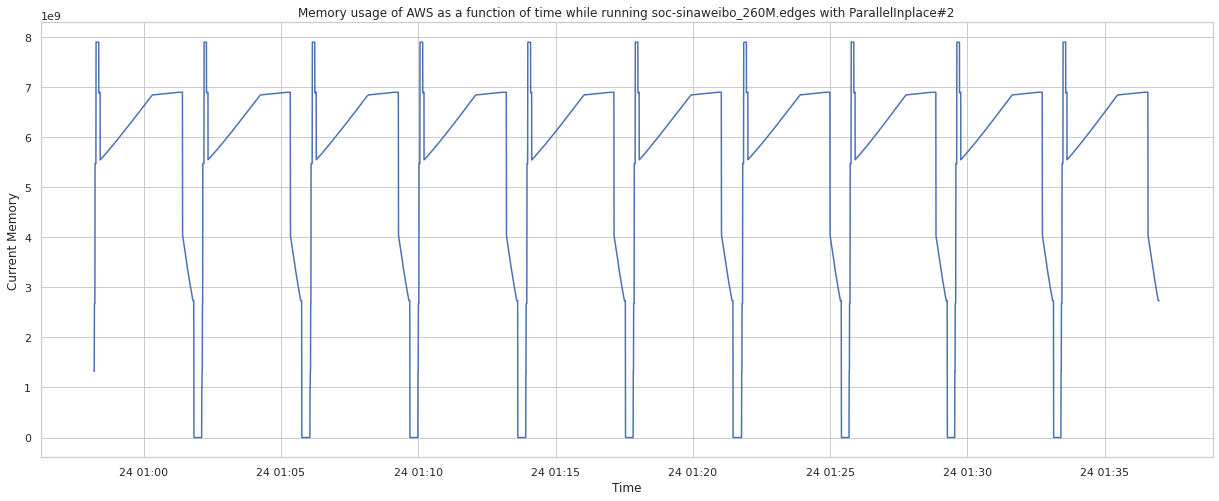

In [157]:
ax=visualise_time(aws_parallel.profile,aws_parallel.dataset.iloc[59]["Start Time"],aws_parallel.dataset.iloc[59]["End Time"],figsize=(21,8))
ax.set_title(f"Memory usage of {aws_parallel.name} as a function of time while running {aws_parallel.dataset.iloc[59]['Graph Name']} with {aws_parallel.dataset.iloc[59]['Type']}")

## 5. Comparing Running time of different algorithms
### 5.1 Legion 5
We note that on Legion 5, by adding more threads, the running time will decrease, but the memory usage increases.
We suspect that this is true until reaching the number of CPU parallel threads support. which is usually equal to:
$$
 n_{#}=2\cdot n_{\text{CPU}}
$$

Text(0.5, 1.0, 'Comparaison of different algorithms on soc-sinaweibo_260M.edges on Legion5')

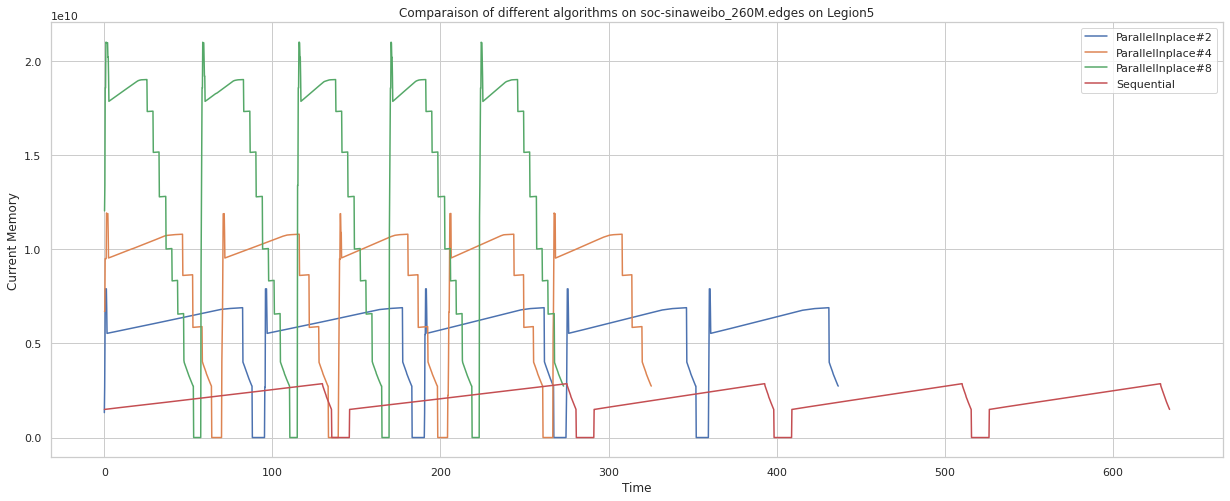

In [158]:
def compare_algorithms(results,graph_name,ax=None):
    for dataset in results:
        for query in dataset.dataset.query(f"`Graph Name`=='{graph_name}'").index:
            visualise_time_relative(dataset.profile,dataset.dataset.iloc[query]["Start Time"],dataset.dataset.iloc[query]["End Time"],ax=ax,label=dataset.dataset.iloc[query]["Type"],normalize=False)
    ax.set_title(f"Comparaison of different algorithms on {graph_name}")
    return ax

fig,ax=plt.subplots(figsize=(21,8))
compare_algorithms([legion5_parallel,legion5_sequential],"soc-sinaweibo_260M.edges",ax=ax)
ax.set_title(ax.title.get_text()+f" on {legion5_sequential.name}")

### 5.2 AWS
On this example, we note that our claim is not true, it can arrive that by adding more threads, the running time will increase while the CPU itself can support that parallelism, this is explained by the fact that only the split and create phase are parallelized, and the merge phase is done in sequential execution. So it can arrive that the merge phase will counteract the performance gain of the split and create phases

<AxesSubplot:title={'center':'Comparaison of different algorithms on socf-konect.edges'}, xlabel='Time', ylabel='Current Memory'>

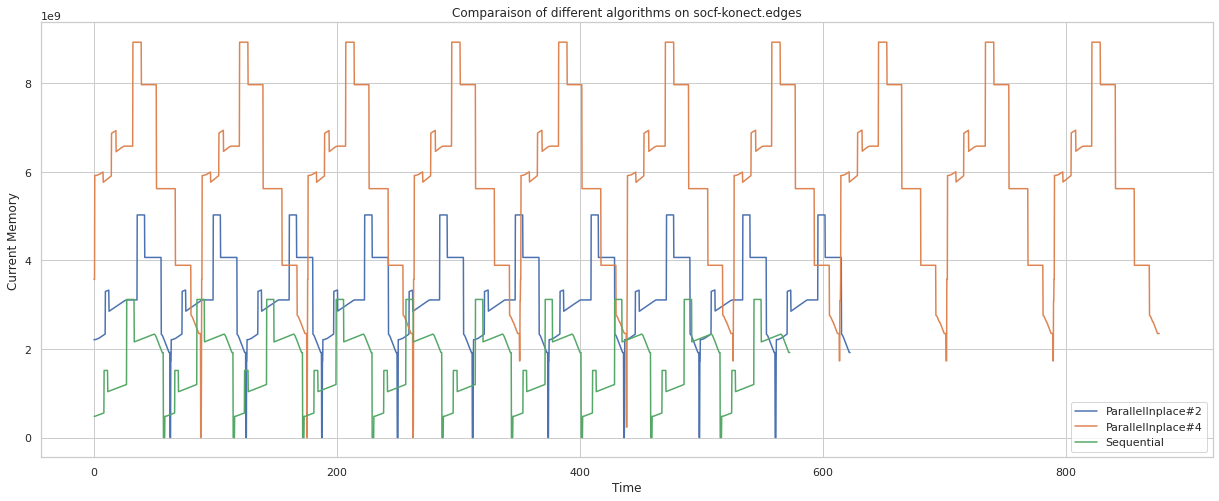

In [159]:
fig,ax=plt.subplots(figsize=(21,8))
compare_algorithms([aws_parallel,aws_sequential],"socf-konect.edges",ax)

## 6. Comparing between different test on different machines

On this section, we will take a graph, and

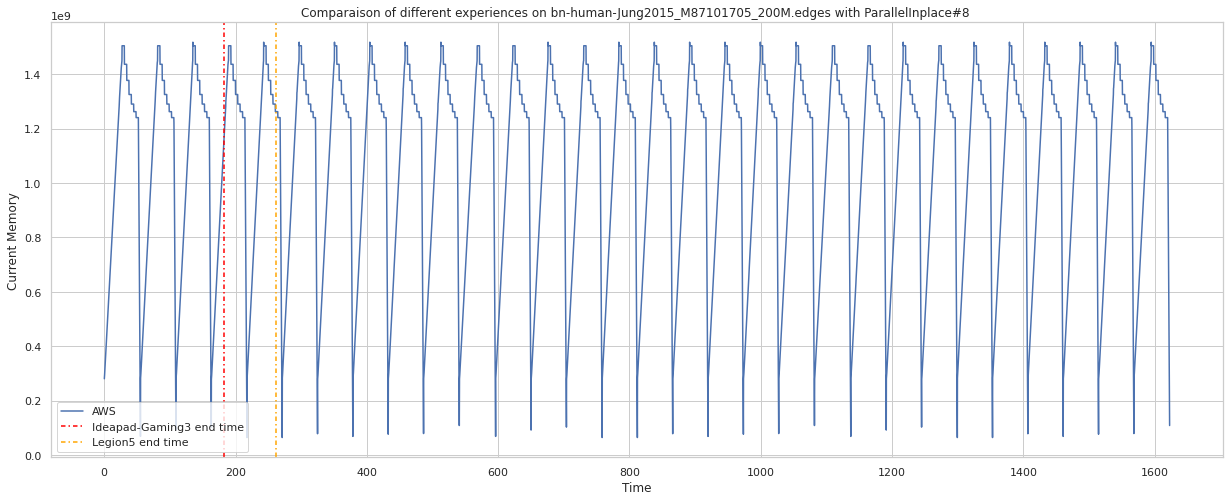

In [160]:
def compare_experiences(results,graph_name,algorithm_type,ax=None,normalize=True,copies=None):
    if copies is None:
        copies=[1]*len(results)
    elif type(copies) == int:
        copies=[copies]*len(results)
    for result,copy in zip(results,copies):
        for query in result.dataset.query(f"`Graph Name` == '{graph_name}' and `Type` == '{algorithm_type}'").index:
            visualise_time_relative(result.profile,result.dataset.iloc[query]["Start Time"],result.dataset.iloc[query]["End Time"],ax=ax,label=result.name,normalize=normalize,copies=copy)
    ax.set_title(f"Comparaison of different experiences on {graph_name} with {algorithm_type} {'normalized' if normalize else '' }")
    return ax

fig,ax=plt.subplots(1,1,figsize=(21,8))
experience_ax=compare_experiences([aws_parallel],"bn-human-Jung2015_M87101705_200M.edges","ParallelInplace#8",ax=ax,normalize=False,copies=3);
experience_ax.axvline(10*ideapad_gaming_parallel.algorithm_execution_time("bn-human-Jung2015_M87101705_200M.edges","ParallelInplace#8").total_seconds(),color="red",
                      label=f"{ideapad_gaming_parallel.name} end time",dashes=(3,2,1,2))
experience_ax.axvline(6*legion5_parallel.algorithm_execution_time("bn-human-Jung2015_M87101705_200M.edges","ParallelInplace#8").total_seconds(),color="orange",
                      label=f"{legion5_parallel.name} end time",dashes=(3,2,1,2))
experience_ax.legend()

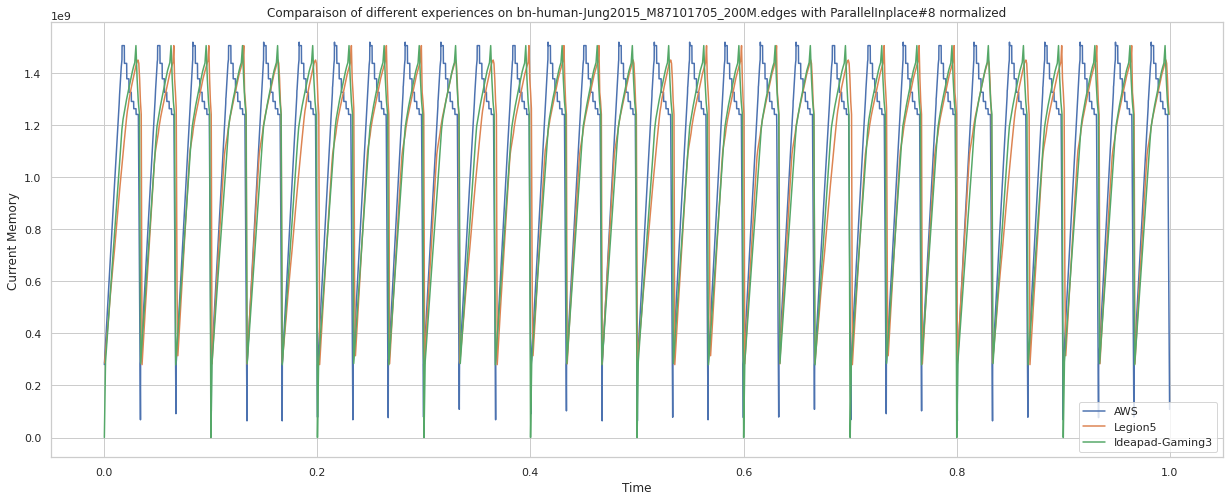

In [161]:

runs=[aws_sequential,aws_parallel,legion5_sequential,legion5_parallel,ideapad_gaming_sequential,ideapad_gaming_parallel]
copies=[3,3,6,6,10,10]
fig,ax=plt.subplots(1,1,figsize=(21,8))
compare_experiences(runs,"bn-human-Jung2015_M87101705_200M.edges","ParallelInplace#8",ax=ax,normalize=True,copies=copies);

## Detailed Analysis
### Importing Graph details

In [162]:
graph_details=pd.read_excel("detailed_results.xlsx")
graph_details=graph_details[list(graph_details.columns[:3])+list(graph_details.columns[5:])]
graph_details=graph_details[graph_details["name"].isin(graph_files)]
graph_details

,name,Field,number_of_edges,number_of_nodes,density,max_degree,min_degree,avg_degree,assortativity,num_triangles,avg_number_of_triangles,max_number_of_triangles,avg_clustering_coef,fraction_closed_triangles,max_k_core,lower_bound_max_clique,link
0,bn-65-1K.edges,Brain,1139.0,65.0,0.547596,72.0,6.0,35.0,0.010197,2.820000e+04,433.0,1200.0,0.708654,0.595333,27.0,11.0,https://networkrepository.com/bn-cat-mixed-spe...
1,bn-100k-662k.edges,Technological Network,662431.0,99600.0,0.000134,125.0,5.0,13.0,455423.000000,3.400000e+06,33.0,369.0,0.431419,0.376667,9.0,5.0,https://networkrepository.com/fe-rotor.php
2,bn-7k-50k.edges,Biological,49788.0,7300.0,0.001882,352.0,2.0,13.0,-0.036859,6.080000e+04,8.0,1400.0,\t0.0244236,0.026621,25.0,7.0,https://networkrepository.com/bio-grid-fruitfl...
3,bn-800-19k.edges,NaN,19176.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,bn-1.8M-166M.edges,NaN,165672643.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66,tech-p2p-gnutella.mtx,Tehnological Network,147878.0,62600.0,0.000076,95.0,1.0,4.0,-0.092730,6.100000e+03,0.0,17.0,0.00546606,0.003872,7.0,4.0,https://networkrepository.com/tech-p2p-gnutell...
67,web-Stanford.mtx,Web,2312497.0,281900.0,0.000058,38600.0,1.0,16.0,-0.096223,4.870000e+07,172.0,382000.0,0.58887,0.012252,87.0,17.0,https://networkrepository.com/web-Stanford.php
68,web-uk-2005.mtx,Web,11744049.0,129600.0,0.001398,850.0,1.0,181.0,0.996939,2.500000e+09,19500.0,124300.0,0.988363,0.999717,500.0,500.0,https://networkrepository.com/web-uk-2005.php
69,web-wikipedia2009.mtx,Web,4507315.0,1900000.0,0.000003,2600.0,1.0,4.0,0.048878,6.700000e+06,3.0,12400.0,0.159551,0.048469,67.0,11.0,https://networkrepository.com/web-wikipedia200...


In [163]:
graph_details=graph_details.rename(columns=lambda name:name.replace("_"," ").title().replace("Avg","Average").replace("Number","Num").replace("Num","Number"))
string_columns=["Name","Field","Link"]
for column in graph_details.columns:
    if column not in string_columns:
        graph_details[column]=graph_details[column].astype(dtype=np.float64)
graph_details=graph_details.apply(lambda V:V.apply(lambda s:s.strip() if type(s)==str else s))

# Justification of Data structure choice

In [164]:
ds=pd.read_csv("data_structure_results.csv")

In [165]:
data_structure_details=ds.merge(graph_details,left_on="Graph Name",right_on="Name")
data_structure_details

,Algorithm Name,Type,Graph Name,Average Time,Average Memory,Name,Field,Number Of Edges,Number Of Nodes,Density,...,Average Degree,Assortativity,Number Triangles,Average Number Of Triangles,Max Number Of Triangles,Average Clustering Coef,Fraction Closed Triangles,Max K Core,Lower Bound Max Clique,Link
0,VectorVectorContainer,Sequential,soc-livejournal.mtx,6.91445,382.346,soc-livejournal.mtx,Social Network,27933062.0,4000000.0,0.000003,...,13.0,0.268845,2.507000e+08,62.0,79700.0,0.256436,0.139259,214.0,87.0,https://networkrepository.com/soc-livejournal.php
1,VectorSetContainer,Sequential,soc-livejournal.mtx,10.13910,1431.770,soc-livejournal.mtx,Social Network,27933062.0,4000000.0,0.000003,...,13.0,0.268845,2.507000e+08,62.0,79700.0,0.256436,0.139259,214.0,87.0,https://networkrepository.com/soc-livejournal.php
2,VectorUnorderedSetContainer,Sequential,soc-livejournal.mtx,11.52900,1371.400,soc-livejournal.mtx,Social Network,27933062.0,4000000.0,0.000003,...,13.0,0.268845,2.507000e+08,62.0,79700.0,0.256436,0.139259,214.0,87.0,https://networkrepository.com/soc-livejournal.php
3,MapVectorContainer,Sequential,soc-livejournal.mtx,18.81710,387.486,soc-livejournal.mtx,Social Network,27933062.0,4000000.0,0.000003,...,13.0,0.268845,2.507000e+08,62.0,79700.0,0.256436,0.139259,214.0,87.0,https://networkrepository.com/soc-livejournal.php
4,MapSetContainer,Sequential,soc-livejournal.mtx,22.19260,1400.760,soc-livejournal.mtx,Social Network,27933062.0,4000000.0,0.000003,...,13.0,0.268845,2.507000e+08,62.0,79700.0,0.256436,0.139259,214.0,87.0,https://networkrepository.com/soc-livejournal.php
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
113,MapUnorderedSetContainer,Sequential,bn-human-Jung2015_M87107781_70M.edges,51.85880,2000.310,bn-human-Jung2015_M87107781_70M.edges,Brain,72523814.0,818500.0,0.000217,...,177.0,0.091979,1.290000e+10,15800.0,1100000.0,0.574911,0.306257,476.0,52.0,https://networkrepository.com/bn-human-Jung201...
114,UnorderedMapVectorContainer,Sequential,bn-human-Jung2015_M87107781_70M.edges,15.97300,438.720,bn-human-Jung2015_M87107781_70M.edges,Brain,72523814.0,818500.0,0.000217,...,177.0,0.091979,1.290000e+10,15800.0,1100000.0,0.574911,0.306257,476.0,52.0,https://networkrepository.com/bn-human-Jung201...
115,UnorderedMapSetContainer,Sequential,bn-human-Jung2015_M87107781_70M.edges,32.07420,2826.680,bn-human-Jung2015_M87107781_70M.edges,Brain,72523814.0,818500.0,0.000217,...,177.0,0.091979,1.290000e+10,15800.0,1100000.0,0.574911,0.306257,476.0,52.0,https://networkrepository.com/bn-human-Jung201...
116,UnorderedMapUnorderedSetContainer,Sequential,bn-human-Jung2015_M87107781_70M.edges,30.54840,1992.950,bn-human-Jung2015_M87107781_70M.edges,Brain,72523814.0,818500.0,0.000217,...,177.0,0.091979,1.290000e+10,15800.0,1100000.0,0.574911,0.306257,476.0,52.0,https://networkrepository.com/bn-human-Jung201...


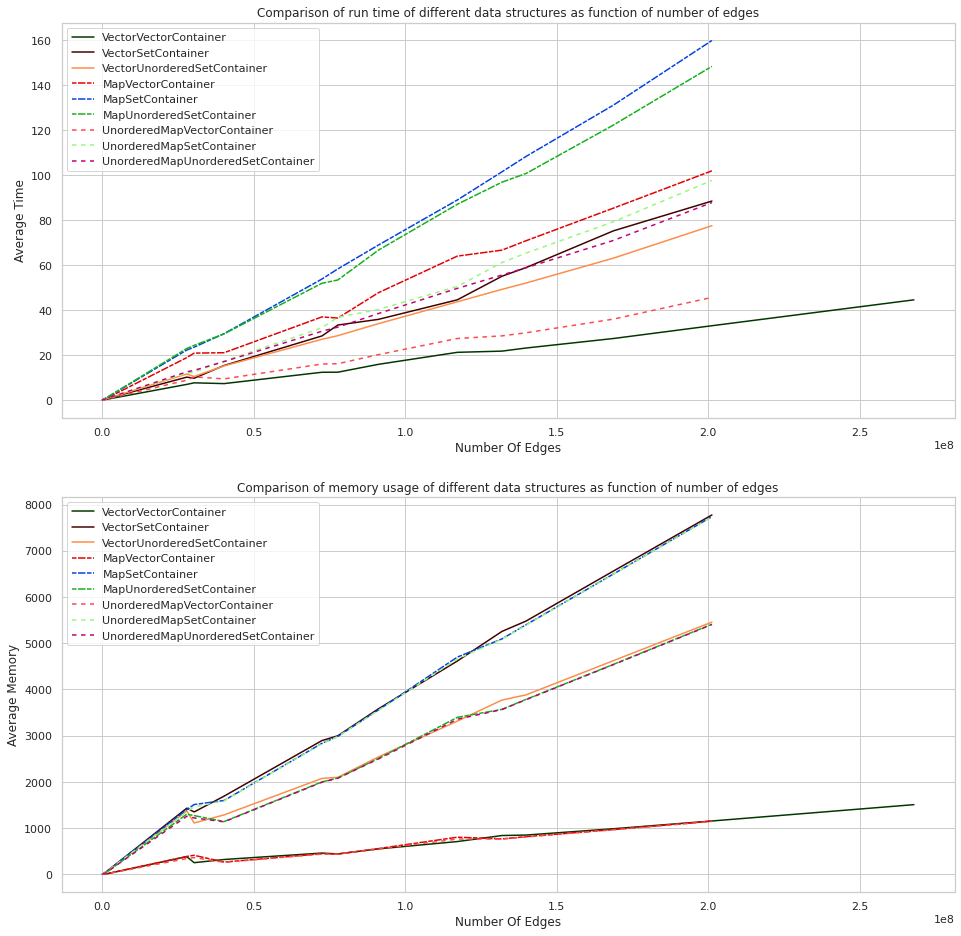

In [166]:
from itertools import cycle
fig,axs=plt.subplots(2,1,figsize=(16,16))
dashes_list=[(),(3,1,5,1),(3,3)]
colors=["xkcd:dark green","xkcd:deep brown","xkcd:orangeish","xkcd:red","xkcd:blue","xkcd:green","xkcd:light red","xkcd:light green","xkcd:magenta"]
for q,ax in zip(["Average Time","Average Memory"],axs):
    sns.lineplot(data=data_structure_details,x="Number Of Edges",y=q,hue="Algorithm Name",ax=ax,dashes=True,palette=cycle(colors))
    for k,line in enumerate(ax.lines):
        line.set_dashes(dashes_list[(k//3)%3])
    ax.legend()

axs[0].set_title("Comparison of run time of different data structures as function of number of edges")
axs[1].set_title("Comparison of memory usage of different data structures as function of number of edges")
fig.savefig("test1.png")

# III. Preprocessing
## 0. Creating Complete dataset

In [247]:
for algorithm_data in datasets:
    algorithm_data.augmented_dataset=graph_details.merge(algorithm_data.full_dataset(),left_on="Name",right_on="Graph Name")
    algorithm_data.augmented_dataset["Number Of Threads"] = algorithm_data.augmented_dataset["Type"].apply(lambda X:nb_threads(X))
graphs_creation_dataset=pd.concat([result.augmented_dataset for result in datasets],ignore_index=True)

## 1. Predicting missing RAM values
We note that the ram usage depends on the graph itself and the number of threads. Statistically, it may suggest that also the memory usage is independent of the hardware itself. But that is false, as a detailed inspection of each algorithm shows that it is dependent on the size of each fundamental type and class, on pointer size, and on memory usage of each STL container. And those values may differ from an architecture to another, and from an STL implementation to another. And it is only by chance that we all used the same STL implementation (GNU's libstc++) and Architecture (x86-64).

Furthermore, by knowing at least the result of one algorithm test on a specific hardware on some graph using a fixed number of threads, we can predict the ram usage of the other test results on the same hardware and same file using linear regression with a good precision.

For that reason, we will complete the missing values using a linear regression on missing values for each file and hardware couple.
### 1.1 Justification

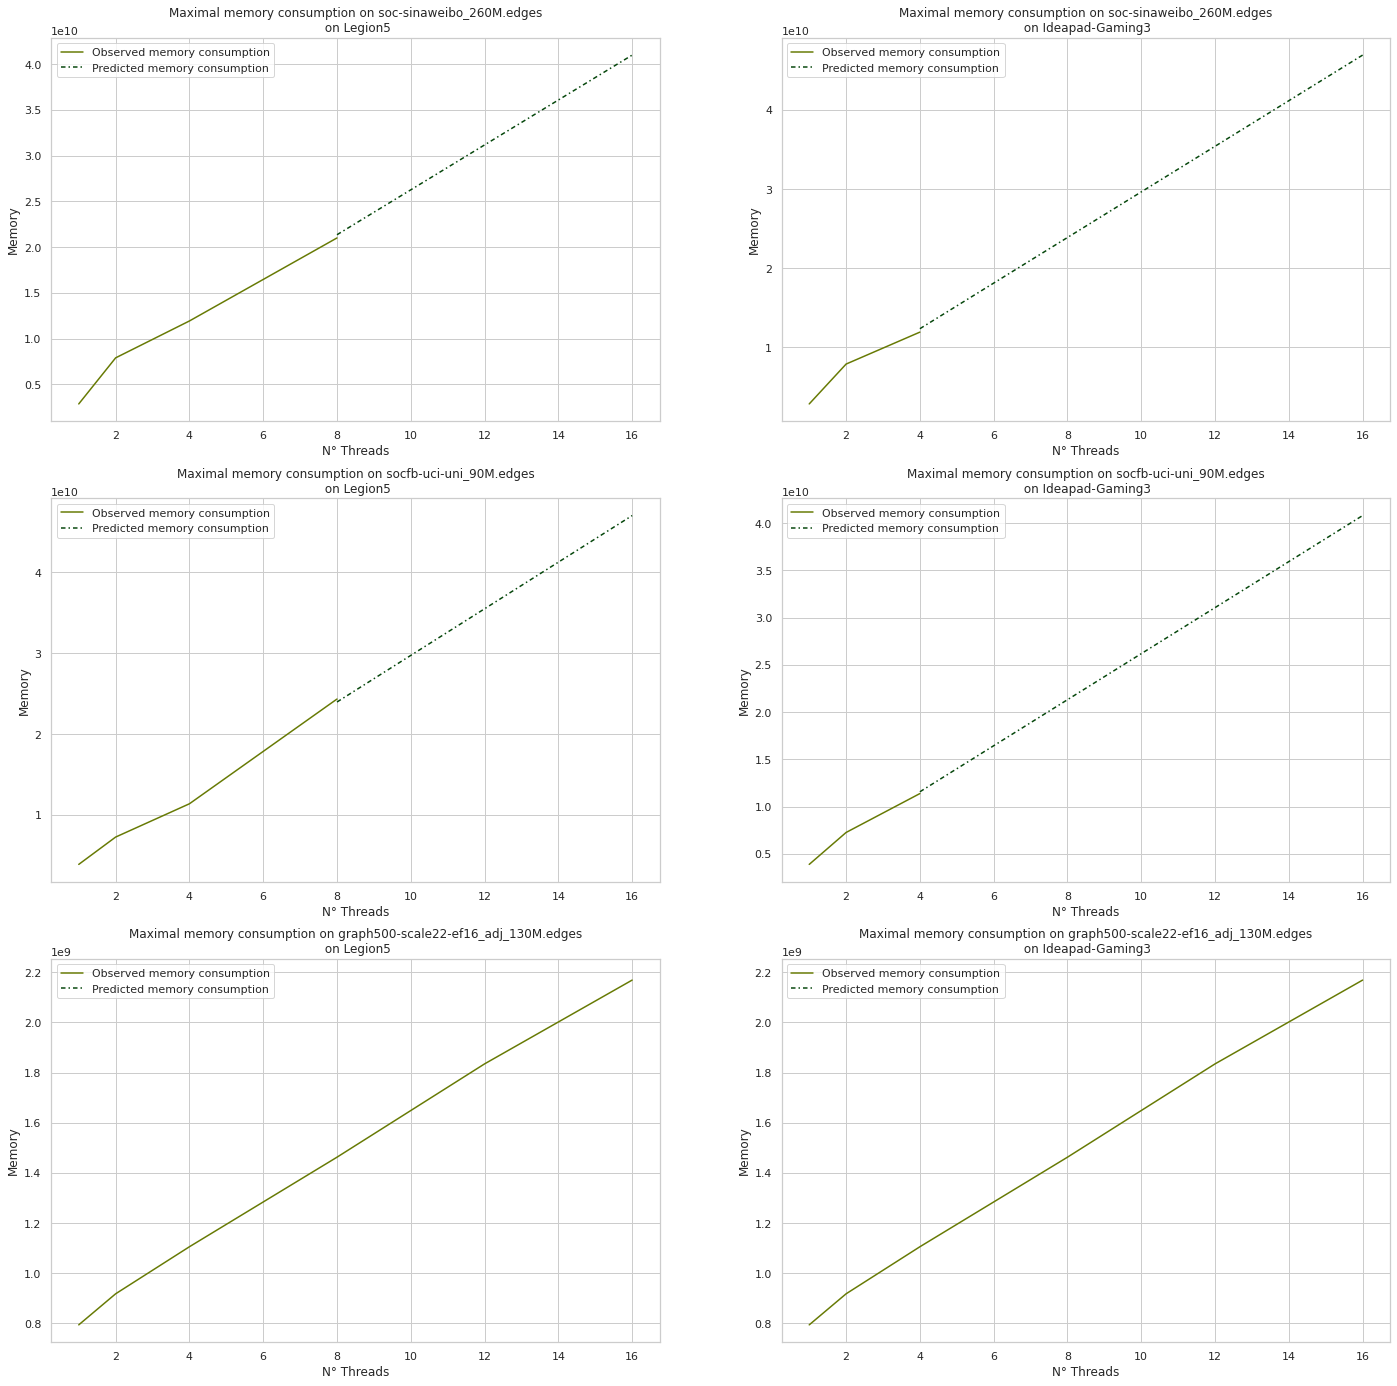

In [300]:
from sklearn.linear_model import LinearRegression

def max_memory_plot(results,graph_name:str,ax=None):
    X=[]
    Y=[]
    name:str
    for result in results:
        name=result.name
        for query in result.dataset.query(f"`Graph Name`=='{graph_name}'").index:
            X.append(nb_threads(result.dataset.iloc[query]["Type"]))
            Y.append(result.dataset.iloc[query]["Average Memory"])
    data=pd.DataFrame({"N° Threads":X,"Memory":Y})
    data["Memory"]=data["Memory"].astype(np.float64)
    actual_data=data.dropna()
    regression = LinearRegression()
    regression.fit(np.reshape(actual_data["N° Threads"].to_numpy(),(-1,1)),actual_data["Memory"].to_numpy())
    projected_data=data[(data["Memory"].isna()) | (data["N° Threads"]==actual_data["N° Threads"].max())].copy()
    projected_data["Memory"]=regression.predict(projected_data["N° Threads"].to_numpy().reshape((-1,1)))
    sns.lineplot(data=actual_data,x="N° Threads",y="Memory",ax=ax,color="xkcd:olive green",label="Observed memory consumption")
    sns.lineplot(data=projected_data,x="N° Threads",y="Memory",ax=ax,color="xkcd:forest green",label="Predicted memory consumption")
    ax.set_title(f"Maximal memory consumption on {graph_name}\n on {name}")
    ax.lines[1].set_dashes((3,2,1,2))
    ax.legend()
    return ax

fig,axs=plt.subplots(3,2,figsize=(24,24))
for axz,run in zip(axs.T,[[legion5_parallel,legion5_sequential],[ideapad_gaming_parallel,ideapad_gaming_sequential]]):
    for ax,graph_name in zip(axz,["soc-sinaweibo_260M.edges","socfb-uci-uni_90M.edges","graph500-scale22-ef16_adj_130M.edges"]):
        ax=max_memory_plot(run,graph_name,ax=ax)
fig.savefig("test.png")

### 1.2 Completing missing RAM values

In [169]:
for graph_name in graph_files:
    for hardware_name in graphs_creation_dataset["Computer Name"].unique():
        mask=(graphs_creation_dataset["Graph Name"]==graph_name) & (graphs_creation_dataset["Computer Name"]==hardware_name)
        nan_mask=np.isnan(graphs_creation_dataset["Average Memory"])
        if not (nan_mask&mask).any() or not (~nan_mask&mask).any():
            continue
        model=LinearRegression()
        sub_dataset=graphs_creation_dataset[mask & ~nan_mask]
        model.fit(sub_dataset["Number Of Threads"].to_numpy().reshape((-1,1)),sub_dataset["Average Memory"])
        graphs_creation_dataset.loc[mask & nan_mask,"Average Memory"] = model.predict(graphs_creation_dataset.loc[mask & nan_mask,"Number Of Threads"].to_numpy().reshape((-1,1)))

graphs_creation_dataset.head(5)

,Name,Field,Number Of Edges,Number Of Nodes,Density,Max Degree,Min Degree,Average Degree,Assortativity,Number Triangles,...,Cpu Cores,Cpu Threads,Cpu Speed,Cpu Cache,Cpu Bogomips,Ram,Disk Cache Speed,Disk Speed,Computer Name,Number Of Threads
0,bn-65-1K.edges,Brain,1139.0,65.0,0.547596,72.0,6.0,35.0,0.010197,28200.0,...,2,4,2499.998,36608,5000.0,16197044,8384.1,151.8,AWS,1
1,bn-100k-662k.edges,Technological Network,662431.0,99600.0,0.000134,125.0,5.0,13.0,455423.000000,3400000.0,...,2,4,2499.998,36608,5000.0,16197044,8384.1,151.8,AWS,1
2,bn-7k-50k.edges,Biological,49788.0,7300.0,0.001882,352.0,2.0,13.0,-0.036859,60800.0,...,2,4,2499.998,36608,5000.0,16197044,8384.1,151.8,AWS,1
3,bn-800-19k.edges,NaN,19176.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,4,2499.998,36608,5000.0,16197044,8384.1,151.8,AWS,1
4,bn-1.8M-166M.edges,NaN,165672643.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2,4,2499.998,36608,5000.0,16197044,8384.1,151.8,AWS,1


## 2. Machine Learning Model
### 3.1 Feature Extraction

In [294]:
import sklearn
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVR,SVR

evident_features=["Number Of Threads","Number Of Edges","Number Of Nodes"]
calculable_features=["Density","Max Degree","Min Degree","Average Degree"]
hard_features=["Assortativity","Number Triangles","Average Number Of Triangles","Max Number Of Triangles","Average Clustering Coef","Fraction Closed Triangles","Max K Core","Lower Bound Max Clique"]
hardware_feature=["Cpu Cores","Cpu Threads","Cpu Speed","Cpu Cache","Disk Cache Speed","Disk Speed"]
targets=["Average Time","Average Memory"]


graphs_creation_ml=graphs_creation_dataset[evident_features+calculable_features+hard_features+hardware_feature+targets]
graphs_creation_ml

,Number Of Threads,Number Of Edges,Number Of Nodes,Density,Max Degree,Min Degree,Average Degree,Assortativity,Number Triangles,Average Number Of Triangles,...,Max K Core,Lower Bound Max Clique,Cpu Cores,Cpu Threads,Cpu Speed,Cpu Cache,Disk Cache Speed,Disk Speed,Average Time,Average Memory
0,1,1139.0,65.0,0.547596,72.0,6.0,35.0,0.010197,2.820000e+04,433.0,...,27.0,11.0,2,4,2499.998,36608,8384.10,151.80,0.4255,8.424000e+03
1,1,662431.0,99600.0,0.000134,125.0,5.0,13.0,455423.000000,3.400000e+06,33.0,...,9.0,5.0,2,4,2499.998,36608,8384.10,151.80,283.4680,8.389900e+06
2,1,49788.0,7300.0,0.001882,352.0,2.0,13.0,-0.036859,6.080000e+04,8.0,...,25.0,7.0,2,4,2499.998,36608,8384.10,151.80,18.7517,4.604040e+05
3,1,19176.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2,4,2499.998,36608,8384.10,151.80,5.8870,1.299960e+05
4,1,165672643.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,2,4,2499.998,36608,8384.10,151.80,45674.5000,1.004890e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1273,1,147878.0,62600.0,0.000076,95.0,1.0,4.0,-0.092730,6.100000e+03,0.0,...,7.0,4.0,8,16,2900.000,512,8473.08,393.25,12.6160,3.222230e+06
1274,1,2312497.0,281900.0,0.000058,38600.0,1.0,16.0,-0.096223,4.870000e+07,172.0,...,87.0,17.0,8,16,2900.000,512,8473.08,393.25,184.3330,2.254160e+07
1275,1,11744049.0,129600.0,0.001398,850.0,1.0,181.0,0.996939,2.500000e+09,19500.0,...,500.0,500.0,8,16,2900.000,512,8473.08,393.25,786.5930,7.284650e+07
1276,1,4507315.0,1900000.0,0.000003,2600.0,1.0,4.0,0.048878,6.700000e+06,3.0,...,67.0,11.0,8,16,2900.000,512,8473.08,393.25,393.0580,6.981490e+07


### 3.2 Memory Prediction Model

In [351]:
U1=graphs_creation_ml[evident_features+hardware_feature+calculable_features+[graphs_creation_ml.columns[-1]]].dropna()
X1=U1[U1.columns[:-1]]
y1=U1[U1.columns[-1]]
X1_train,X1_test,y1_train,y1_test = train_test_split(X1,y1)
memory_pipeline = Pipeline([("scaler",MinMaxScaler()),("regression",DecisionTreeRegressor())])
memory_pipeline.fit(X1_train,y1_train)
memory_pipeline.score(X1_test,y1_test)

0.9975382258239263

### 3.3 Time Prediction Model

In [352]:
U2=graphs_creation_ml[evident_features+hardware_feature+calculable_features+[graphs_creation_ml.columns[-2]]].dropna()
X2=U2[U2.columns[:-1]]
y2=U2[U2.columns[-1]]
X2_train,X2_test,y2_train,y2_test = train_test_split(X2,y2)
time_pipeline = Pipeline([("scaler",MinMaxScaler()),("regression",RandomForestRegressor())])
time_pipeline.fit(X2_train,y2_train)
time_pipeline.score(X2_test,y2_test)

0.9623225894546809

### 3.4 Algorithm Prediction Model

In [448]:
class GraphPredictionModel:
    def __init__(self,memory_model,time_model,parallel_threads_limit=64):
        self.memory_model=memory_model
        self.time_model=time_model
        self.parallel_threads_limit=64
        self.debug=False

    def fit(self,X,Y):
        if type(Y)==np.ndarray:
            self.memory_model.fit(X,Y[:,0])
            self.time_model.fit(X,Y[:,1])
        else:
            self.memory_model.fit(X,Y["Average Memory"])
            self.time_model.fit(X,Y["Average Time"])
        return self
    def fit_independently(self,X_memory,y_memory,X_time,y_time):
        self.memory_model.fit(X_memory,y_memory)
        self.time_model.fit(X_time,y_time)
        return self

    def predict(self,X,memory_limit,parallel_threads_limit=None,threads=None):
        if threads is None:
            if parallel_threads_limit is None:
                parallel_threads=self.parallel_threads_limit
            bit_floor=int(np.log2(self.parallel_threads_limit))
            threads=np.power(2,np.arange(bit_floor))
        else:
            threads=np.array(threads)
        if type(X)==np.ndarray:
            Z=np.c_[np.zeros((X.shape[0],1)),X]
        elif type(X)==pd.DataFrame:
            Z=X.copy()
            Z["Number Of Threads"]=0
        else:
            raise Exception()
        memory_prediction=np.zeros((threads.shape[0],X.shape[0]))
        time_prediction=np.zeros((threads.shape[0],X.shape[0]))
        for k,thread_count in enumerate(threads):
            if type(X)==np.ndarray:
                Z[:,0]=thread_count
            else:
                Z["Number Of Threads"]=thread_count
            print(memory_prediction)
            memory_prediction[k,:]=self.memory_model.predict(Z)
            time_prediction[k,:]=self.memory_model.predict(Z)
        mask=memory_prediction > memory_limit
        result= threads[np.argmin(np.ma.array(time_prediction,mask=mask),axis=0)]
        return (result,memory_prediction,time_prediction,mask) if self.debug else result

    def predict_independently(self,X_memory,X_time,memory_limit,parallel_threads_limit=None,threads=None):
        if threads is None:
            if parallel_threads_limit is None:
                parallel_threads=self.parallel_threads_limit
            bit_floor=int(np.log2(self.parallel_threads_limit))
            threads=np.power(2,np.arange(bit_floor))
        else:
            threads=np.array(threads)
        if type(X_memory)==np.ndarray:
            Z_memory=np.c_[np.zeros((X_memory.shape[0],1)),X_memory]
        elif type(X_memory)==pd.DataFrame:
            Z_memory=X_memory.copy()
            Z_memory["Number Of Threads"]=0
        else:
            raise Exception()
        if type(X_time)==np.ndarray:
            Z_time=np.c_[np.zeros((X_time.shape[0],1)),X_time]
        elif type(X_memory)==pd.DataFrame:
            Z_time=X_time.copy()
            Z_time["Number Of Threads"]=0
        else:
            raise Exception()
        memory_prediction=np.zeros((threads.shape[0],X_memory.shape[0]))
        time_prediction=np.zeros((threads.shape[0],X_time.shape[0]))
        for k,thread_count in enumerate(threads):
            if type(X_memory)==np.ndarray:
                Z_memory[:,0]=thread_count
            else:
                Z_memory["Number Of Threads"]=thread_count
            if type(X_time)==np.ndarray:
                Z_time[:,0]=thread_count
            else:
                Z_time["Number Of Threads"]=thread_count
            memory_prediction[k,:]=self.memory_model.predict(Z_memory)
            time_prediction[k,:]=self.time_model.predict(Z_time)
        mask=memory_prediction > memory_limit
        result= threads[np.argmin(np.ma.array(time_prediction,mask=mask),axis=0)]
        return (result,memory_prediction,time_prediction,mask) if self.debug else result

    def score(self,X,Y):
        if type(Y)==np.ndarray:
            return (self.memory_model.score(X,Y[:,0]),self.time_model.score(X,Y[:,1]))
        else:
            (self.memory_model.score(X,Y["Average Memory"]),self.time_model.score(X,Y["Average Time"]))
    def score_independently(self,X_memory,y_memory,X_time,y_time):
        return (self.memory_model.score(X_memory,y_memory),self.time_model.score(X_time,y_time))

In [449]:
model=GraphPredictionModel(memory_model=memory_pipeline,time_model=time_pipeline).fit_independently(X1_train,y1_train,X2_train,y2_train)
model.debug=True
(result,M,T,mask)=model.predict_independently(X1_test,X2_test,5e8,threads=np.arange(20))

In [447]:
model.score_independently(X1_test,y1_test,X2_test,y2_test)

(1.0, 0.9960473842465836)

In [450]:
T

array([[ 1483.2485  ,  2520.60743 ,   328.373624, ...,  8430.4152  ,
        19471.561   ,   433.77289 ],
       [ 1483.2485  ,  2520.60743 ,   328.373624, ...,  8430.4152  ,
        19471.561   ,   433.77289 ],
       [ 1456.7609  ,  2355.89553 ,   312.21011 , ...,  8293.6141  ,
        16959.905   ,   401.34472 ],
       ...,
       [ 2546.0072  ,  1123.27534 ,   137.5633  , ...,  2207.6623  ,
        21518.772   ,   536.46829 ],
       [ 2546.0072  ,  1123.27534 ,   137.5633  , ...,  2207.6623  ,
        21518.772   ,   536.46829 ],
       [ 2546.0072  ,  1123.27534 ,   137.5633  , ...,  2207.6623  ,
        21518.772   ,   536.46829 ]])

In [451]:
result

array([ 2,  9,  9,  2,  0,  0,  0,  2,  9,  2,  2,  6, 15, 15,  0,  2,  0,
        0,  0,  0,  0,  0,  0,  2,  0,  0,  2,  3,  9,  0,  0,  0,  2,  0,
        0,  2,  2,  2,  0,  2, 15,  2,  0,  0,  0,  3,  0,  0,  0,  9,  0,
       15,  0,  0,  0,  0, 10,  0,  0, 12,  2, 15,  2,  2,  3,  2, 15,  6,
       12,  0,  2,  0,  2,  3,  2, 15, 10,  9,  0,  9,  6,  0,  3, 15,  5,
        0,  2,  6,  3,  3,  2,  2,  0, 15,  3, 12,  3,  0,  0,  0,  3,  0,
       15,  2,  0,  9,  0,  2,  3, 10,  0,  0,  5,  0,  0,  2, 15,  0, 12,
        0,  2,  5,  0,  0,  9, 12,  0,  2,  0, 15, 15,  0,  2,  0,  0, 15,
        3,  0,  0,  0,  0,  0,  0,  2,  0,  0,  0,  0, 15,  0,  0,  2,  0,
       12,  0,  0,  0, 15,  0,  0,  0,  0,  2,  0, 15,  2,  0,  6, 15,  0,
        0,  2, 15,  0,  0,  0,  2,  0,  2, 10,  0,  0,  0, 12,  0,  0, 15,
       15,  0,  0,  9,  0, 15,  0,  0,  2,  0,  2,  0,  9,  2,  6,  2,  0,
        0,  2,  0,  0,  6,  9,  0,  3,  0,  0,  0,  2,  0,  0,  2,  3, 10,
        2,  5,  0, 12,  5

In [452]:
M

array([[1.55547e+08, 1.72233e+08, 1.55565e+08, ..., 8.80513e+08,
        2.06877e+08, 3.40494e+08],
       [1.55547e+08, 1.72233e+08, 1.55565e+08, ..., 8.80513e+08,
        2.06877e+08, 3.40494e+08],
       [1.97701e+08, 1.96527e+08, 2.16257e+08, ..., 9.68121e+08,
        3.43868e+08, 4.72964e+08],
       ...,
       [8.30448e+08, 6.57590e+08, 6.63683e+08, ..., 1.46433e+09,
        1.01533e+09, 9.92214e+08],
       [8.30448e+08, 6.57590e+08, 6.63683e+08, ..., 1.46433e+09,
        1.01533e+09, 9.92214e+08],
       [8.30448e+08, 6.57590e+08, 6.63683e+08, ..., 1.46433e+09,
        1.01533e+09, 9.92214e+08]])